# Model Explainability

In grid ecosystem, it is imperative that the model predictions and important features are explainable enough for the grid operators and users to make decisions accurately. 

Hence we use Shapley Plots to explain the __overall feature contributions & summary__ and __individual instance predictions__.

SHAP (SHapley Additive exPlanations) is a powerful, model-agnostic method that uses game theory to fairly distribute a model's prediction among its input features, providing local explanations for individual predictions. By calculating Shapley values, SHAP quantifies each feature's contribution (positive or negative) to a specific prediction, allowing users to understand which features are most influential and how they affect the outcome. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# SHAP imports
try:
    import shap
    shap.initjs()
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not available. Install with: pip install shap")

# Additional interpretation imports
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Imports from Helper functions
from helper.common import prepare_data,create_feature_tier_mapping
from helper.load_save_model import load_saved_model
from helper.shap_explain import create_shap_explainer, calculate_shap_values,plot_shap_summary,analyze_feature_importance_by_tier
from helper.shap_explain import plot_tier_based_feature_importance,explain_single_prediction, calculate_permutation_importance_by_tier,visualize_single_shap_explanation

In [2]:
DATA_PATH = r'./data/vsb-power-line-fault-detection/'
FEATURE_PATH = r"./features//"
CHUNK_SIZE = 1000
SAMPLE_SIZE=1000
BEST_MODEL_PATH = r'saved_models\best_model_catboost_fast_20250928_173554.pkl'

### Loading Features for Explanations

In [3]:
# Step 1: Load and prepare data with optimized features
feature_df  = pd.read_parquet(f"{FEATURE_PATH}/final_features.parquet")

In [4]:
data_splits = prepare_data(feature_df, target_col='target',random_state=123)

Preparing data for model training...
Feature matrix shape: (5000, 124)
Target distribution:
target
0    0.9336
1    0.0664
Name: proportion, dtype: float64
Training set: 3200 samples
Validation set: 800 samples
Test set: 1000 samples


In [5]:
X_train, X_test, y_train, y_test = data_splits['X_train'],data_splits['X_test'],data_splits['y_train'], data_splits['y_test']

In [6]:
model, metadata = load_saved_model(BEST_MODEL_PATH)

✓ Loaded model: saved_models\best_model_catboost_fast_20250928_173554.pkl


In [7]:
feature_names = X_train.columns

### Creating Feature Tiers

In [8]:
feature_tier_mapping = create_feature_tier_mapping(feature_names)

### Creating Shap Explainer and Shap values

In [9]:
# Create SHAP explainer

explainer = create_shap_explainer(model, X_train, model_tier="Tier 2",max_background_size=2000)

Creating SHAP explainer...
Using background sample of 2000 points
Using TreeExplainer for tree-based model


In [10]:
shap_values, X_explain = calculate_shap_values(explainer, X_test,max_explain_size=2000)

Calculating SHAP values...
Explaining 1000 samples
SHAP values calculated. Shape: (1000, 124)


### Visualizing Shap Summary Plot

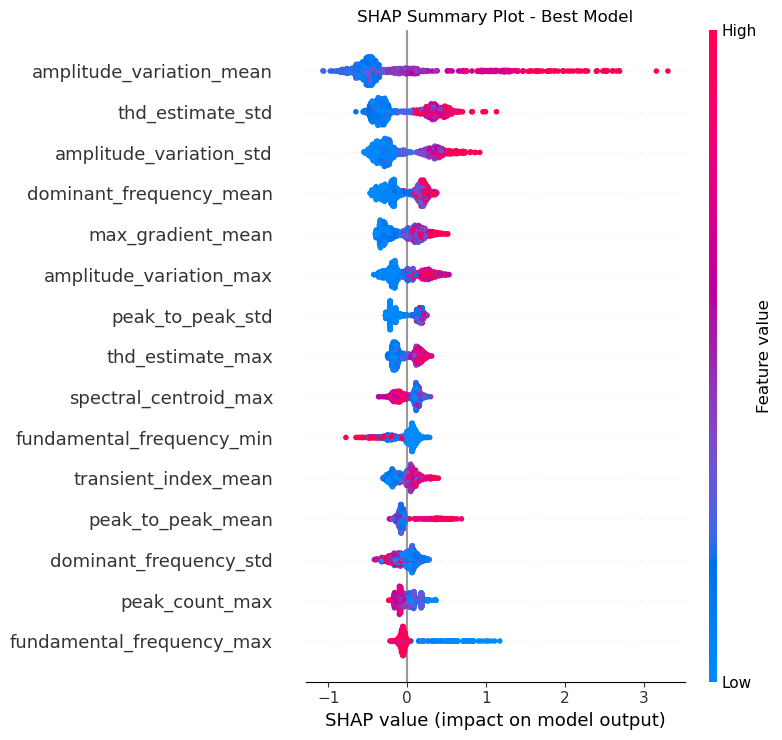

In [11]:
plot_shap_summary(shap_values, X_explain, feature_names, "Best Model")

### Explanation: 

* On X-axis - the positive values push the model toward predicting fault condition and negatgive values towards normal condition
* On Y-axis - features are ranked by the importance from top and each dot represents 1 data sample
* Color pink/red indicates higher feature values, blue a lower feature value and purple medium feature values.

Top 5 Important Features are 
1. amplitude_variation_mean - Higher positive feature value indicates faults - Faults causes amplitude fluctions as seen in EDA
2. thd_estimate_std - Higher positive value indicates faults - higher Total Harmonic Means shows distortions in signal, indicating fault
3. amplitude_variation_std  - similar to 1
4. dominant_frequency_mean - Frequency shifts are strong fault indicators
5. max_gradient_mean - Higher gradients (sharp signal changes) indicate faults
6. peak_to_peak_std - Higher standard deviation between two peaks indicates faults
7. fundamental_frequency_min/max - shows bidrectional effects-> Deviations from nominal frequency (both high and low) can indicate faults

__Minimal overlap between blue and red suggests good model performance__

#### For System Monitoring

* Priority monitoring: Focus on amplitude variation and THD metrics
* Redundancy: Multiple features provide robustness against sensor failures
* Early warning: Gradual changes in top features may indicate developing faults

### Feature Importance by Feature Tiers

In [12]:
importance_df = analyze_feature_importance_by_tier(shap_values, feature_names,feature_tier_mapping)

Feature Importance by Computational Tier:
                       mean_importance  total_importance  feature_count
tier                                                                   
Power System Specific           0.1290            2.5809             20
Tier 1: Ultra-fast              0.0314            1.7598             56
Tier 2: Fast                    0.0301            0.8442             28
Tier 3: Advanced                0.0611            1.2229             20

Tier Efficiency Analysis:
Power System Specific: 0.1290 importance per feature
Tier 1: Ultra-fast: 0.0314 importance per feature
Tier 2: Fast: 0.0301 importance per feature
Tier 3: Advanced: 0.0611 importance per feature


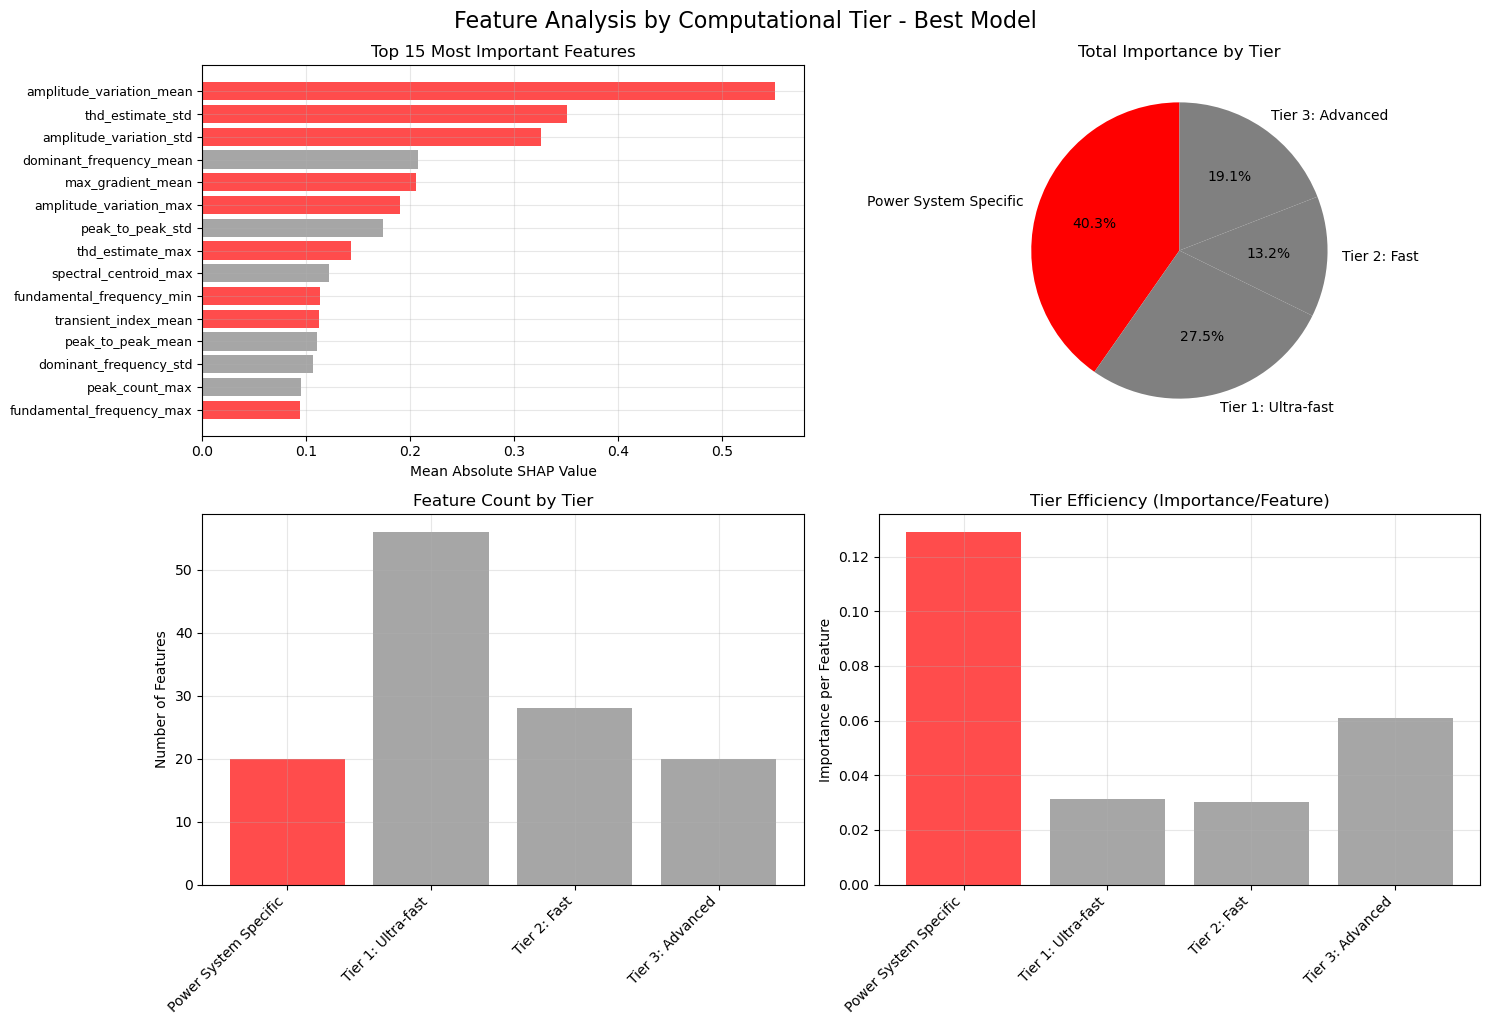

In [13]:
# Visualizing Tier based feature Importance

plot_tier_based_feature_importance(importance_df, "Best Model")

### Explanation:

* Power System Specific Features have highest per-feature importance and most total contribution despite having fewer features
* Tier-3 Advances features showcase good feature per importance ratio compared to Tier 1 adn 2

If we need to choose features, Power System Specific features and Tier 3 Advanced features should be given highest priority followed by Tier 1 and Tier 2 features as supplements as needed. Domain knowledge is more valuable in this model than generic statistical features in Tier 1

### Single Prediction Explanation

In [14]:
y_pred = model.predict(X_test)

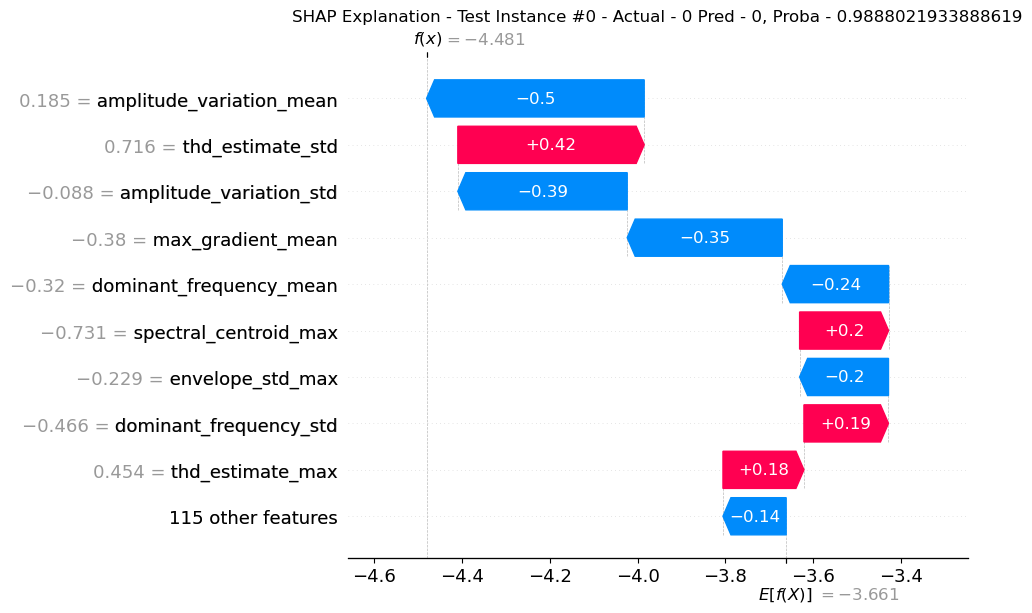

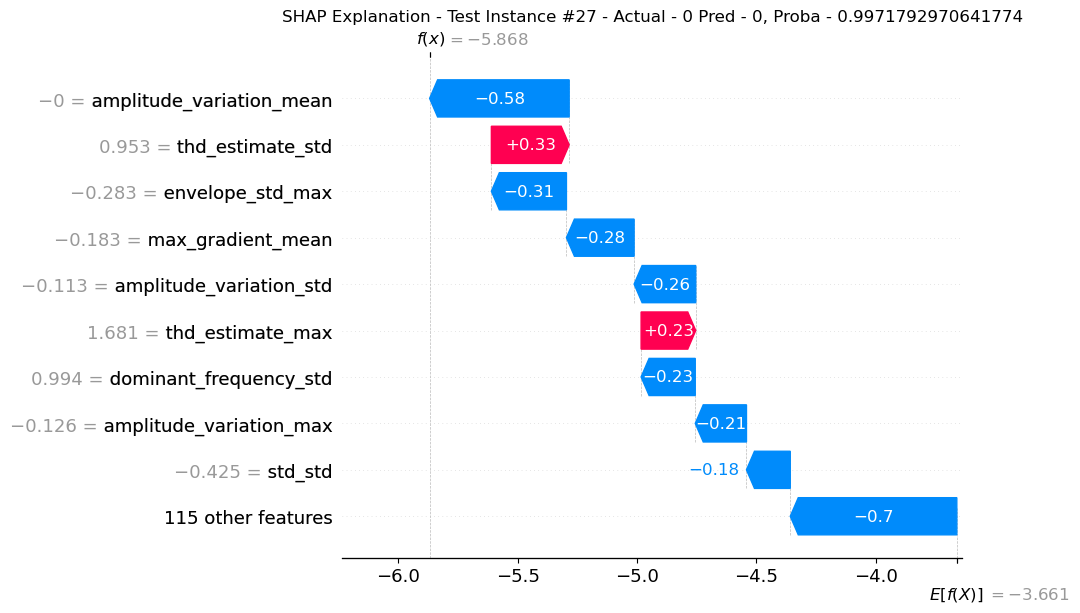

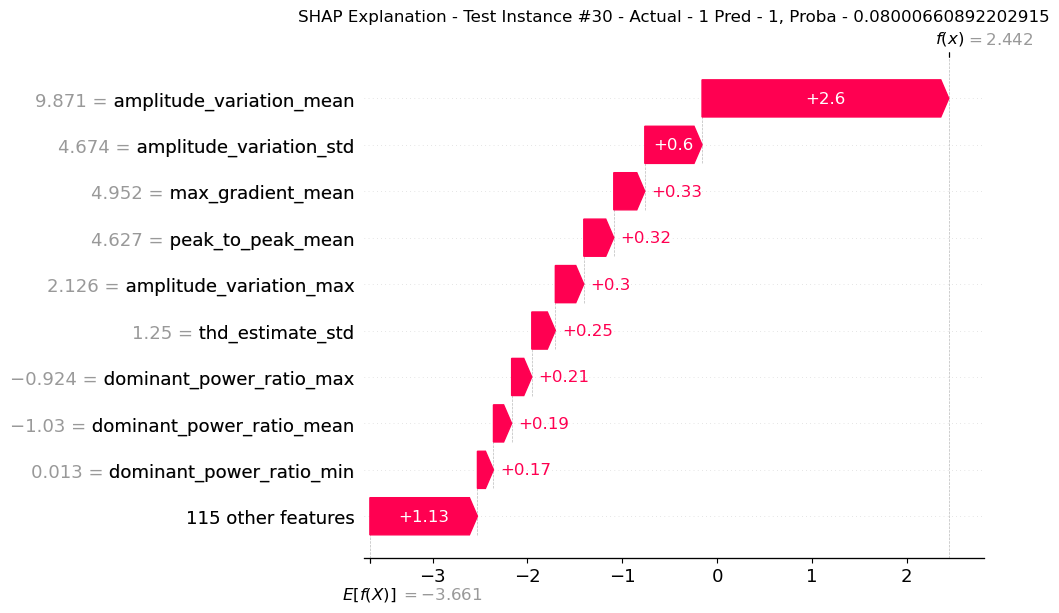

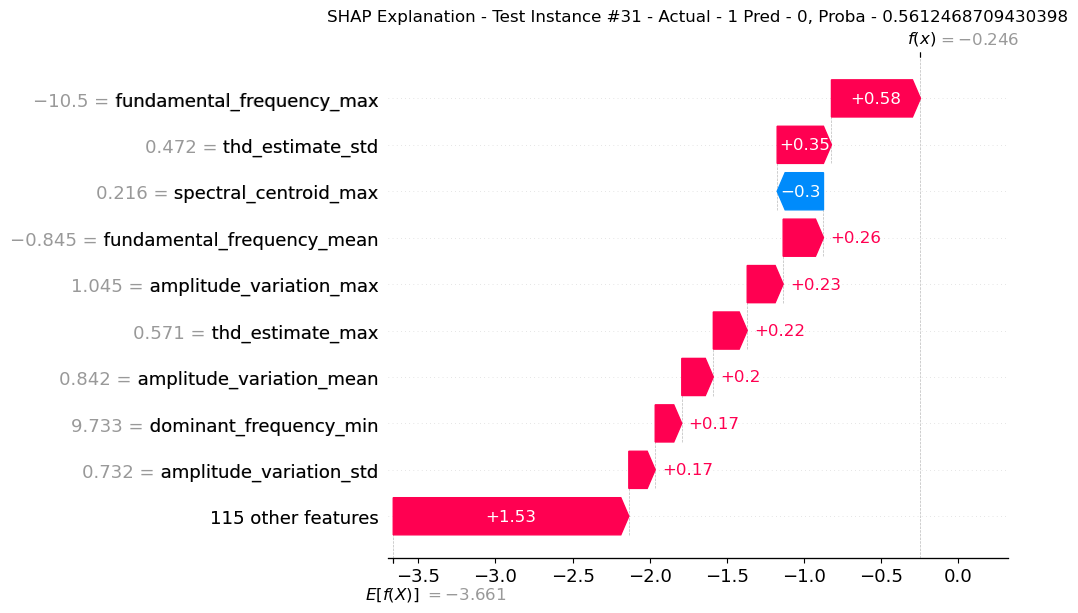

In [15]:
# 6. Explain sample predictions
explanations = []
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
for i in [0,27,30,31]:
    visualize_single_shap_explanation(
    explainer=explainer,
    instance=X_test.iloc[i],  # First test instance
    model = model,
    shap_values = shap_values,
    X_explain = X_explain,
    instance_id = i,
    feature_names=feature_names,
    plot_type='waterfall',
    
    title=f'SHAP Explanation - Test Instance #{i} - Actual - {y_test.iloc[i]} Pred - {y_pred[i]}, Proba - {y_pred_proba[i][0]}')

## Explanation

1. First two instances (0 & 27): 
* Model output _f(x)_ is -4.4 and -5.8, which shows strong normal prediction
* Majors features are blue and have negative SHAP values which indicates normal prediction

2. Instance #30 is correctly predicted as Fault Signal

* Model output f(x) = +2.4 which shows strong fault prediciton
* All features strongly indicate fault with red bards and positive SHAP values

3. Instance 31 is a misclassified Instance (False Negative)

* Model output f(x) = -0.24, which is weak normal prediction, even the probabilities are 0.5 which might have caused the missclassification
* This shows that the decision boundary might needs adjustment to get better predictions
* SHAP values shows that except the third feature, all the others shows positive SHAP values and red bars
* Faults signals are weak in #31 compared to #30


Strong Normal indicators are low amplitude variations, stable frequencies and low gradients
Strong Fault indicators are high amplitude variations, frequency deviations and high THD variations

### End of Model Explainability